In [16]:
import random
import numpy as np
import torch
from rdkit import Chem


# for reproducability
rd_seed = 42

torch.manual_seed(rd_seed)
np.random.seed(rd_seed)
random.seed(rd_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
import pandas as pd
train_df = pd.read_csv("../input/train.csv")
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [ ]:
train_df.info()

<AxesSubplot:>

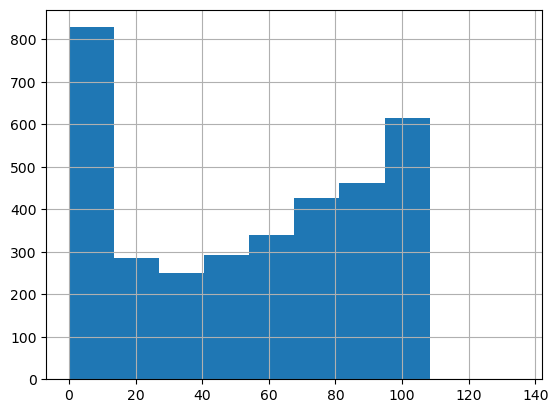

In [23]:
train_df["HLM"].hist()

In [39]:
np.sqrt(((train_df["MLM"] - (train_df["MLM"]//10*10+5) )**2).mean())

3.340439066492132

In [40]:
train_df["MLM"]

0       26.010
1       29.270
2        5.586
3        5.710
4       93.270
         ...  
3493     1.556
3494    35.560
3495    56.150
3496     0.030
3497     0.450
Name: MLM, Length: 3498, dtype: float64

In [38]:
train_df["MLM"]//10 * 10+5

0       25.0
1       25.0
2        5.0
3        5.0
4       95.0
        ... 
3493     5.0
3494    35.0
3495    55.0
3496     5.0
3497     5.0
Name: MLM, Length: 3498, dtype: float64

In [ ]:
mol = Chem.MolFromSmiles(train_df['SMILES'][1000])
mol

---


In [ ]:
from pytorch_tabnet.tab_network import AttentiveTransformer, FeatTransformer
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.nn as nn

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles # Converts a SMILES string to a torch_geometric.data.Data instance.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class GraphFeature(nn.Module):
    def __init__(self, node_feat, embed_dim):
        super(GraphFeature, self).__init__()

        self.conv_l1 = GCNConv(node_feat, 8)
        self.conv_l2 = GCNConv(8, 16)
        self.embedding = nn.Linear(16, embed_dim)

    def forward(self, x, edge_idx, batch):
        x = F.elu(self.conv_l1(x, edge_idx))
        x = F.elu(self.conv_l2(x, edge_idx))
        x = global_mean_pool(x, batch) # read-out layer

        x = self.embedding(x)
        return x

In [ ]:
class GraphNet(nn.Module):
    def __init__(self, graph_dict, num_heads, reg_emb, drop_ratio, out_dim):
        super(GraphNet, self).__init__()

        
        self.graph_feature = GraphFeature(graph_dict["node_feat"], graph_dict["embed_dim"])

        self.attn_layer = nn.MultiheadAttention(graph_dict["embed_dim"], num_heads, dropout=drop_ratio)

        self.regressor = nn.Sequential( nn.Linear(graph_dict["embed_dim"] , reg_emb),
                                        nn.BatchNorm1d(reg_emb),
                                        nn.ELU(),
                                        nn.Dropout(p=drop_ratio),
                                        nn.Linear(reg_emb, reg_emb),
                                        nn.ELU(),
                                        nn.Dropout(p=drop_ratio),
                                        nn.Linear(reg_emb, out_dim))
        
        
    def forward(self, node_attr, edge_idx, batch):
        graph_feat = self.graph_feature(node_attr, edge_idx, batch)
        graph_feat.to(device)

        attn_output = self.attn_layer(graph_feat, graph_feat)
        attn_output = attn_output[0]

        res = self.regressor(attn_output)
        return res  

In [ ]:
class MultiDataset(Dataset):
    def __init__(self, dataFrame):
        super(MultiDataset, self).__init__()

        self.train_df = dataFrame
        self.train_df.fillna(0, inplace=True)
        self.graph_list = self.smiles2mol(train_df["SMILES"])

        self.target_mlm = torch.tensor(self.train_df["MLM"].values.astype(np.float32))
        self.target_hlm = torch.tensor(self.train_df["HLM"].values.astype(np.float32))

        self.wo_smiles_df = self.train_df.drop(columns=["SMILES", "id", "MLM", "HLM"], axis=1)
        self.wo_smiles_df = torch.tensor(self.wo_smiles_df.values.astype(np.float32))

    
    def smiles2mol(self, smiles_list):
        print('Convert "SMILES" data to mol')

        graph_list = []
        for smiles in tqdm(smiles_list):
            graph_data = from_smiles(smiles)

            graph_data.smiles = None
            graph_data.edge_attr = None

            graph_list.append(graph_data)

        print('Complete!')
        return graph_list
    
    def __getitem__(self, idx):
        return self.graph_list[idx], self.wo_smiles_df[idx], self.target_mlm[idx], self.target_hlm[idx]
    
    def __len__(self):
        return len(self.graph_list)


In [ ]:
train_dataset = MultiDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=128)

In [ ]:
len(train_dataset)

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat, y))
        return loss

In [ ]:
graph_params = {
    'node_feat': 9,
    'embed_dim': 32
}

In [ ]:
model = GraphNet(graph_params, 3, 32, 0.1, 1)


In [ ]:
EPOCHS = 100
model.to(device)

criterion = RMSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

losses = list()

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for graph, tabular, mlm, _ in train_dataloader:

        graph_x = graph.x.type(torch.float32).to(device)
        graph_edge_idx = graph.edge_index.to(device)
        graph_batch = graph.batch.to(device)

        tabular = tabular.to(device)
        mlm = mlm.view(-1,1).to(device)

        optimizer.zero_grad()
        predict = model(graph_x, graph_edge_idx, graph_batch)
